In [21]:
import tensorflow as tf
import numpy as np

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))
from datetime import datetime
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from utils import plot, plt, compare_images, run_http_server

import threading
%matplotlib inline

# Load the TensorBoard notebook extension
%load_ext tensorboard

print(f'tf version = {tf.__version__}')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
tf version = 2.0.0


In [8]:
# consts
DATA_ROOT = './data/leapGestRecog'
IMAGE_SHAPE = (150, 150)
EPOCHS = 5
BATCH_SIZE = 128
NUM_CLASSES = 10
LOG_DIR = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
MODEL_PATH = 'models/leapHandGesture.h5'

## Loading Data
This project uses the Hand Gesture Recognition Database (citation below) available on Kaggle. It contains 20000 images with different hands and hand gestures. There is a total of 10 hand gestures of 10 different people presented in the data set. There are 5 female subjects and 5 male subjects.
The images were captured using the Leap Motion hand tracking device.

In [9]:
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.1)
image_data_train = image_generator.flow_from_directory(
    str(DATA_ROOT), 
    target_size=IMAGE_SHAPE,
    color_mode="grayscale",
    subset='training'
)
image_data_validation = image_generator.flow_from_directory(
    str(DATA_ROOT), 
    target_size=IMAGE_SHAPE,
    color_mode="grayscale",
    subset='validation')

image_data_train.batch_size = BATCH_SIZE


label_names = ['Palm', 'L', 'Fist', 'Fist moved', 'Thumb', 'Index', 'Ok', 'Palm moved', 'C', 'down']

Found 18000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


Image batch shape:  (128, 150, 150, 1)
Label batch shape:  (128, 10)


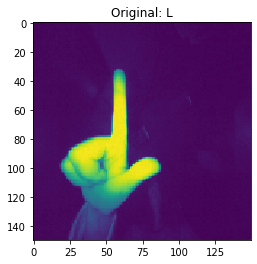

In [10]:
SHOW_INDEX = 0
image_batch, label_batch = next(image_data_train)
print("Image batch shape: ", image_batch.shape)
print("Label batch shape: ", label_batch.shape)
plt.title(f'Original: {label_names[np.argmax(label_batch[SHOW_INDEX])]}')
_ = plt.imshow(np.squeeze(image_batch[SHOW_INDEX])) 

In [11]:
model = tf.keras.models.Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (*IMAGE_SHAPE,1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))

model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 32)      832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 18, 18, 96)       

In [12]:
# training
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR, update_freq='epoch')
# %tensorboard --logdir $LOG_DIR

history = model.fit_generator(image_data_train,
                    epochs=EPOCHS, 
                    steps_per_epoch = image_data_train.samples // BATCH_SIZE,
                    validation_data = image_data_validation, 
                    validation_steps = image_data_validation.samples // BATCH_SIZE,
                    callbacks=[tensorboard_callback])
# save the weights
model.save(MODEL_PATH) 

Epoch 1/5
140/140 [==============================] - 389s 3s/step - loss: 0.2772 - acc: 0.9058 - val_loss: 1.1751 - val_acc: 0.8000
Epoch 2/5
140/140 [==============================] - 447s 3s/step - loss: 8.5208e-04 - acc: 0.9997 - val_loss: 1.1929 - val_acc: 0.8083
Epoch 3/5
140/140 [==============================] - 429s 3s/step - loss: 9.1643e-05 - acc: 1.0000 - val_loss: 0.8714 - val_acc: 0.8083
Epoch 4/5
140/140 [==============================] - 416s 3s/step - loss: 1.5841e-05 - acc: 1.0000 - val_loss: 0.8610 - val_acc: 0.8313
Epoch 5/5
140/140 [==============================] - 431s 3s/step - loss: 9.6558e-06 - acc: 1.0000 - val_loss: 0.8929 - val_acc: 0.8375


In [13]:
# Import DeepExplain
from deepexplain.tf.v2_x import DeepExplain

with DeepExplain(session=tf.compat.v1.keras.backend.get_session()) as de:  # <-- init DeepExplain context
    new_model = tf.keras.models.load_model(MODEL_PATH)
    
    # 1. Get the input tensor to the original model
    input_tensor = new_model.layers[0].input
    output_tensor = new_model.layers[-2].output
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs=output_tensor)
    
    # target_tensor = fModel(input_tensor) # <- crash here!!!!!!
    target_tensor = fModel(fModel.layers[0].input)
    
    image_batch, label_batch = next(image_data_validation)

    
    xs = image_batch[0:10]
    ys = label_batch[0:10]
    ys_pred = fModel.predict(xs)
    
    attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys)
    attributions_ig    = de.explain('intgrad', target_tensor, input_tensor, xs, ys=ys)

Using tf version = 2.0.0
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/home/ax/miniconda3/envs/masterThesis_tf_2/lib/python3.6/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


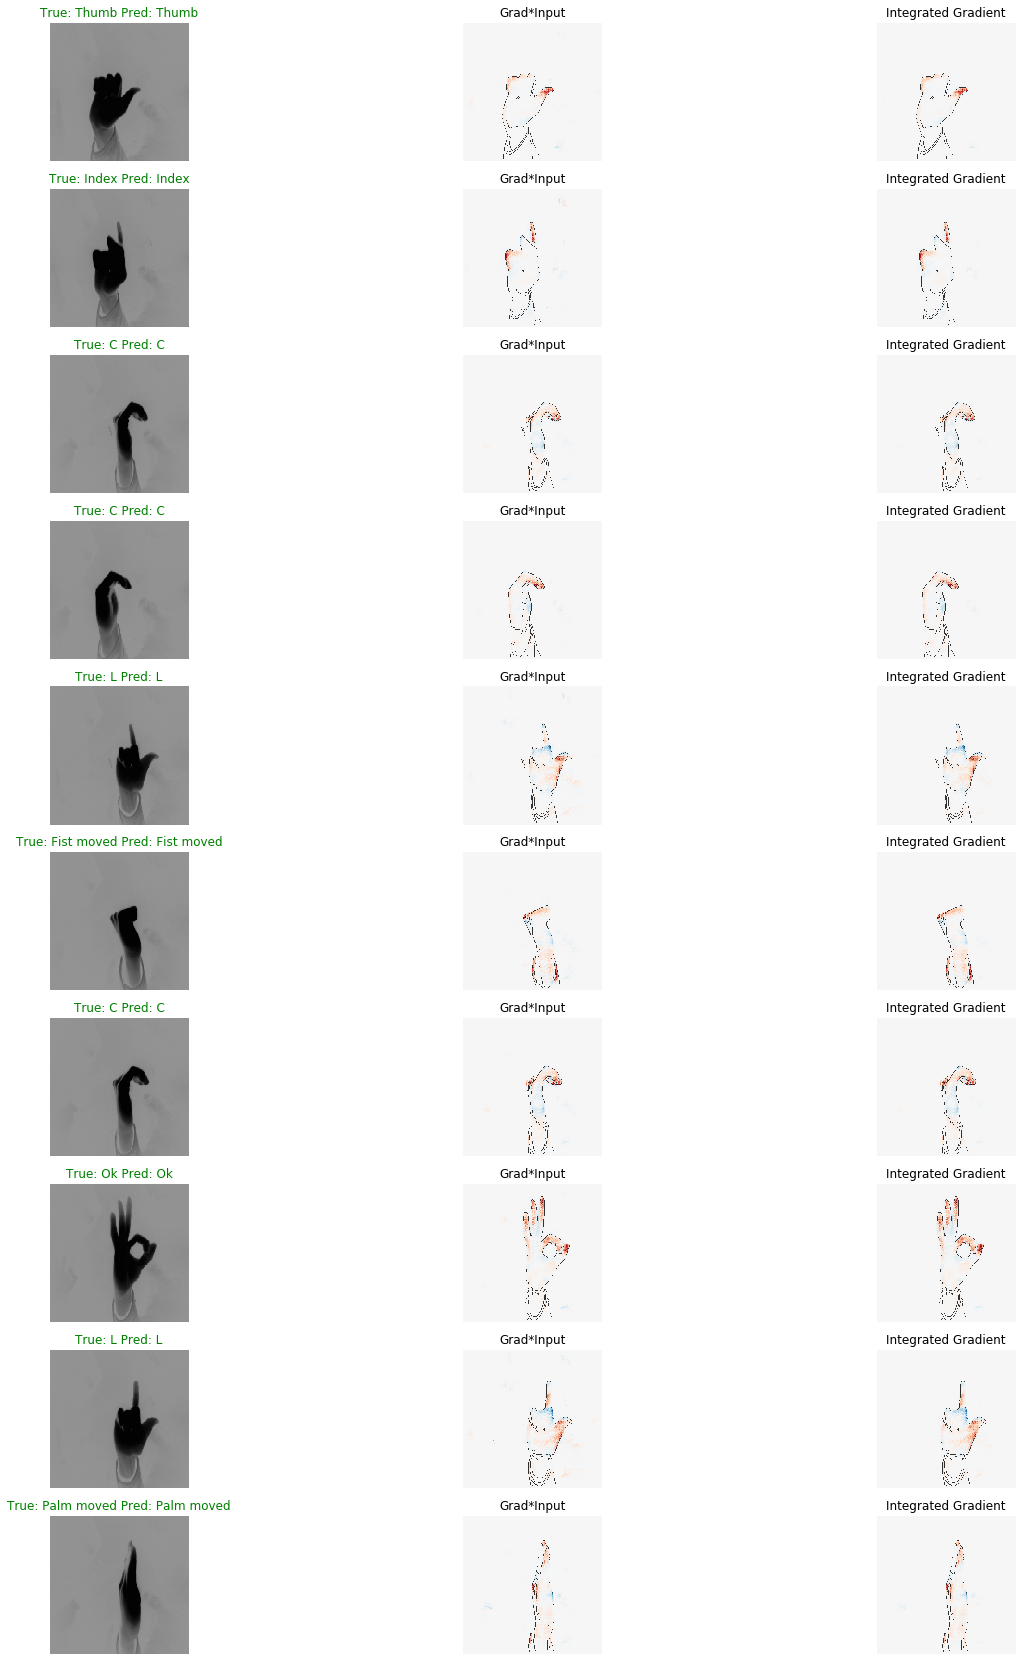

In [14]:
n_cols = 3
n_rows = int(len(attributions_gradin))
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(7*n_cols, 3*n_rows))

for i, (a1, a2) in enumerate(zip(attributions_gradin, attributions_ig)):
    row, col = divmod(i, 1)
    true_label = label_names[np.argmax(ys[i])]
    pred_label = label_names[np.argmax(ys_pred[i])]
    plot(xs[i].reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]), cmap='Greys', axis=axes[row, 0]) \
    .set_title(f'True: {true_label} Pred: {pred_label}', color='green' if true_label == pred_label else 'red')
    plot(a1.reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]), xi = xs[i], axis=axes[row,1]).set_title('Grad*Input')
    plot(a2.reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]), xi = xs[i], axis=axes[row,2]).set_title('Integrated Gradient')

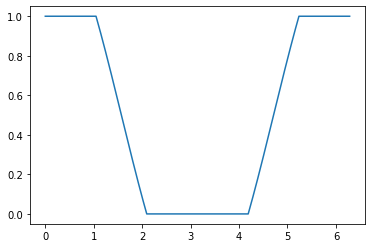

In [21]:
import matplotlib as mpl
# make the colormaps
cmap1 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap',['blue','red'],256)
cmap1._init() # create the _lut array, with rgba values

# create your alpha array and fill the colormap with them.
# here it is progressive, but you can create whathever you want
alphas = np.linspace(0, 2 * np.pi, cmap1.N+3)
cmap1._lut[:,-1] = list(map(lambda x : np.clip(np.cos(x) + 0.5, 0.0, 1.0), alphas)) 


fig, ax = plt.subplots()
ax.plot(alphas, cmap1._lut[:,-1])

In [18]:
threading \
    .Thread(target=run_http_server, args=(8000,)) \
    .start()


serving at port 8000


In [30]:
import importlib
import utils
importlib.reload(utils)
from utils import compare_images

In [42]:
cmp_index = 7

true_label = label_names[np.argmax(ys[cmp_index])]
pred_label = label_names[np.argmax(ys_pred[cmp_index])]
print(f'True: {true_label} Pred: {pred_label}')
img1 = xs[cmp_index].reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1])
img2 = attributions_gradin[cmp_index].reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1])

compare_images(img1, img2)


True: Ok Pred: Ok


127.0.0.1 - - [23/Dec/2019 18:38:23] "GET /html/first.png HTTP/1.1" 200 -
127.0.0.1 - - [23/Dec/2019 18:38:23] "GET /html/second.png HTTP/1.1" 200 -
